In [1]:
import sys
# Aggiungi il percorso della cartella che contiene utils.py a sys.path
sys.path.append('../utils')

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import svm
from sklearn.multioutput import MultiOutputRegressor
sns.set_theme(style='darkgrid')

from sklearn.model_selection import GridSearchCV, learning_curve

from sklearn.metrics import make_scorer
from utils import save_plot, mean_euclidean_error, root_mean_squared_error, multidim_r2
from joblib import dump

In [3]:
TRAIN_DATA = os.path.join('..', '..', 'datasets', 'cup2023', 'ML-CUP23-TR.csv')
IMAGES_FOLDER = os.path.join('..', '..', 'images', 'cup2023', 'SVR')
MODEL_FOLDER = os.path.join('..', '..', 'trained_models', 'cup2023')

In [4]:
# To skip the first column (row indexes)
columns_to_read = list(range(1, 14))

df_train = pd.read_csv(TRAIN_DATA, header=None, comment='#', usecols=columns_to_read, delimiter=',')
df_train = df_train.astype('float64') #casting
df_train.head()

,1,2,3,4,5,6,7,8,9,10,11,12,13
0,-0.917280,-0.712727,-0.989904,0.992819,0.993649,0.995543,0.711074,0.407645,-0.688548,0.616890,7.897453,-35.936382,21.077147
1,-0.858784,0.998755,-0.998396,0.999909,0.316503,-0.951897,-0.163139,0.980982,0.661759,-0.800155,-9.330632,19.901571,6.069154
2,-0.990441,0.958726,-0.998675,0.997216,0.987166,0.356483,-0.279689,0.599163,-0.684630,0.922901,14.849400,3.374090,19.667479
3,0.937117,0.984474,-0.612420,0.999812,0.728623,-0.539962,-0.165939,0.999352,-0.921444,-0.974766,-46.591854,13.734777,17.953600
4,-0.906628,-0.884567,-0.932487,0.941037,0.978134,0.998179,0.749606,-0.590599,-0.508268,0.691798,8.217500,-45.885254,14.894251


In [5]:
features = ['feature_' + str(i) for i in range(1, 11)]
targets = ['target_x', 'target_y', 'target_z']

# Rename columns
new_column_names = features + targets
df_train.columns = new_column_names

df_train.head()

,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,target_x,target_y,target_z
0,-0.917280,-0.712727,-0.989904,0.992819,0.993649,0.995543,0.711074,0.407645,-0.688548,0.616890,7.897453,-35.936382,21.077147
1,-0.858784,0.998755,-0.998396,0.999909,0.316503,-0.951897,-0.163139,0.980982,0.661759,-0.800155,-9.330632,19.901571,6.069154
2,-0.990441,0.958726,-0.998675,0.997216,0.987166,0.356483,-0.279689,0.599163,-0.684630,0.922901,14.849400,3.374090,19.667479
3,0.937117,0.984474,-0.612420,0.999812,0.728623,-0.539962,-0.165939,0.999352,-0.921444,-0.974766,-46.591854,13.734777,17.953600
4,-0.906628,-0.884567,-0.932487,0.941037,0.978134,0.998179,0.749606,-0.590599,-0.508268,0.691798,8.217500,-45.885254,14.894251


In [6]:
from sklearn.model_selection import train_test_split

X = df_train[features].to_numpy()
y = df_train[targets].to_numpy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) #TODO split potenzialmente variabile?

# Create model

In [7]:
mee_scorer = make_scorer(mean_euclidean_error, greater_is_better=False)
rmse_scorer = make_scorer(root_mean_squared_error, greater_is_better=False)
multidim_r2_scorer = make_scorer(multidim_r2, greater_is_better=True)

scoring = {'MEE': mee_scorer, 'R2': multidim_r2_scorer, 'RMSE': rmse_scorer}

In [8]:
# Definizione del modello SVR
svr = svm.SVR()

# Creazione di un MultiOutputRegressor
model = MultiOutputRegressor(svr)

In [9]:
param_grid = [
    {'svr__estimator__kernel': ['linear'], 'svr__estimator__C': [0.1, 1, 10, 100], 'svr__estimator__epsilon': [0.01, 0.1, 1]},
    {'svr__estimator__kernel': ['rbf'], 'svr__estimator__C': [0.1, 1, 10, 100], 'svr__estimator__gamma': [0.1, 0.01, 0.001, 0.0001], 'svr__estimator__epsilon': [0.01, 0.1, 1]},
    {'svr__estimator__kernel': ['poly'], 'svr__estimator__C': [0.1, 1, 10, 100], 'svr__estimator__degree': [2, 3, 4], 'svr__estimator__gamma': [0.001, 0.0001], 'svr__estimator__coef0': [0, 1, 2], 'svr__estimator__epsilon': [0.01, 0.1, 1]},
    {'svr__estimator__kernel': ['sigmoid'], 'svr__estimator__C': [0.1, 1, 10, 100], 'svr__estimator__gamma': [0.001, 0.0001], 'svr__estimator__coef0': [0, 1, 2], 'svr__estimator__epsilon': [0.01, 0.1, 1]}
]

In [10]:
# Definizione del pipeline con RobustScaler e un modello Ridge
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import RobustScaler

'''
Scales input data using RobustScaler with the formula: (X - median(X)) / IQR,
where IQR is the interquartile range (75th - 25th percentile). This scaler is
chosen for its robustness to outliers, utilizing the median rather than the mean.
It is particularly beneficial for algorithms that are sensitive to the scale of data,
like neural networks, where it promotes zero mean and unit variance, leading to faster
gradient descent convergence. It also improves algorithms based on distance measures
(e.g., K-nearest neighbors, hierarchical clustering) and those assuming data normality.
However, algorithms such as Random Forest, which do not rely on distance or data normality,
may not see as much benefit from scaling.

Parameters:
X_train (array-like): Input data to be scaled.

Returns:
scaled_data (array-like): Scaled version of X_train.
'''

pipeline = Pipeline([
    ('scaler', RobustScaler()),
    ('svr', model)
])

In [11]:
grid_search = GridSearchCV(
    pipeline,
    param_grid=param_grid,
    cv=5,
    scoring=scoring,
    refit='MEE',
    n_jobs=-1,
    verbose=2
)
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 348 candidates, totalling 1740 fits
[CV] END svr__estimator__C=0.1, svr__estimator__epsilon=0.01, svr__estimator__kernel=linear; total time=   0.0s
[CV] END svr__estimator__C=1, svr__estimator__epsilon=0.01, svr__estimator__kernel=linear; total time=   0.1s
[CV] END svr__estimator__C=1, svr__estimator__epsilon=0.1, svr__estimator__kernel=linear; total time=   0.1s
[CV] END svr__estimator__C=10, svr__estimator__epsilon=0.01, svr__estimator__kernel=linear; total time=   0.3s
[CV] END svr__estimator__C=10, svr__estimator__epsilon=1, svr__estimator__kernel=linear; total time=   0.1s
[CV] END svr__estimator__C=100, svr__estimator__epsilon=0.01, svr__estimator__kernel=linear; total time=   0.7s
[CV] END svr__estimator__C=100, svr__estimator__epsilon=1, svr__estimator__kernel=linear; total time=   0.5s
[CV] END svr__estimator__C=0.1, svr__estimator__epsilon=0.01, svr__estimator__gamma=0.001, svr__estimator__kernel=rbf; total time=   0.1s
[CV] END svr__estimator__C=

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', RobustScaler()),
                                       ('svr',
                                        MultiOutputRegressor(estimator=SVR()))]),
             n_jobs=-1,
             param_grid=[{'svr__estimator__C': [0.1, 1, 10, 100],
                          'svr__estimator__epsilon': [0.01, 0.1, 1],
                          'svr__estimator__kernel': ['linear']},
                         {'svr__estimator__C': [0.1, 1, 10, 100],
                          'svr__estimator__epsilon': [0.01, 0.1, 1],
                          'svr__estimator__gamma'...
                         {'svr__estimator__C': [0.1, 1, 10, 100],
                          'svr__estimator__coef0': [0, 1, 2],
                          'svr__estimator__epsilon': [0.01, 0.1, 1],
                          'svr__estimator__gamma': [0.001, 0.0001],
                          'svr__estimator__kernel': ['sigmoid']}],
             refit='MEE',
             scoring={'MEE': make_scorer(mean_euclidean_error, greater_is_better=False),
                      'R2': make_scorer(multidim_r2),
                      'RMSE': make_scorer(root_mean_squared_error, greater_is_better=False)},
             verbose=2)

In [12]:
results = pd.DataFrame(grid_search.cv_results_)
# results.to_csv('grid_search_SVR_results.csv', index=False)

In [13]:
'''
Quando si utilizza grid_search.best_score_ in scikit-learn e si ottiene un valore negativo,
ciò è tipicamente dovuto al fatto che scikit-learn trasforma alcune funzioni di scoring in modo 
che possano essere trattate come funzioni di "massimizzazione". '''


best_params = grid_search.best_params_
best_index = grid_search.best_index_

mee = grid_search.best_score_
r2 = grid_search.cv_results_['mean_test_R2'][best_index]
rmse = grid_search.cv_results_['mean_test_RMSE'][best_index]

print('Best parameters:', best_params)
print('Best MEE score:', abs(mee))
print('R2:', abs(r2))
print('RMSE:', abs(rmse))

Best parameters: {'svr__estimator__C': 100, 'svr__estimator__epsilon': 0.1, 'svr__estimator__gamma': 0.1, 'svr__estimator__kernel': 'rbf'}
Best MEE score: 1.1509219010543243
R2: 0.9979753863492753
RMSE: 0.8919392182458112


In [14]:
adapted_params = {'C': best_params['svr__estimator__C'],
                  'epsilon': best_params['svr__estimator__epsilon'],
                  'kernel': best_params['svr__estimator__kernel']}

if best_params['svr__estimator__kernel'] != 'linear':
    adapted_params['gamma'] = best_params['svr__estimator__gamma']

if best_params['svr__estimator__kernel'] in ['poly', 'sigmoid']:
    adapted_params['degree'] = best_params.get('svr__estimator__degree')
    adapted_params['coef0'] = best_params.get('svr__estimator__coef0')

In [15]:
# Definizione del modello SVR
svr = svm.SVR(**adapted_params)

# Creazione di un MultiOutputRegressor
model = MultiOutputRegressor(svr)

final_model = Pipeline([
    ('scaler', RobustScaler()),
    ('svr', model)
])

final_model.fit(X_train, y_train)

Pipeline(steps=[('scaler', RobustScaler()),
                ('svr', MultiOutputRegressor(estimator=SVR(C=100, gamma=0.1)))])

# Learning curve

In [16]:
train_sizes, train_scores, validation_scores = learning_curve(
    estimator=final_model,
    X=X_train,
    y=y_train,
    train_sizes=[0.1, 0.33, 0.55, 0.78, 1.],
    cv=5,
    scoring=mee_scorer
)

In [17]:
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
validation_scores_mean = np.mean(validation_scores, axis=1)
validation_scores_std = np.std(validation_scores, axis=1)

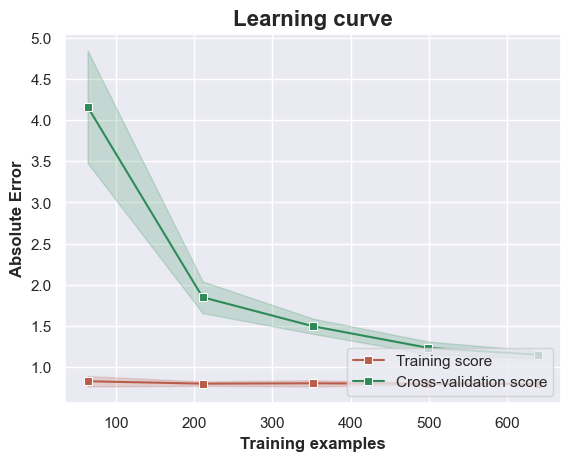

In [18]:
plt.figure()
plt.title('Learning curve', fontweight='bold', fontsize=16)
plt.xlabel('Training examples', fontweight='bold')
plt.ylabel('Absolute Error', fontweight='bold')
plt.grid(True)

color1 = sns.dark_palette((20, 60, 50), input='husl')[-1]
color2 = sns.dark_palette('seagreen')[-1]

# Filling the area around the mean scores to indicate variability of the model's performance
# The shaded area represents the range of scores (mean ± standard deviation) for each training set size
plt.fill_between(
    train_sizes, np.abs(train_scores_mean - train_scores_std),
                 np.abs(train_scores_mean + train_scores_std), alpha=0.2, color=color1
)
plt.fill_between(
    train_sizes, np.abs(validation_scores_mean - validation_scores_std),
                 np.abs(validation_scores_mean + validation_scores_std), alpha=0.2, color=color2
)

# Mean score lines for training and validation
sns.lineplot(x=train_sizes, y=np.abs(train_scores_mean), marker='s', color=color1, label='Training score')
sns.lineplot(x=train_sizes, y=np.abs(validation_scores_mean), marker='s', color=color2, label='Cross-validation score')
plt.legend(loc='lower right')

save_plot(plt, IMAGES_FOLDER, 'learning_curve')
plt.show()

# Plot temp map

In [19]:
results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_svr__estimator__C,param_svr__estimator__epsilon,param_svr__estimator__kernel,param_svr__estimator__gamma,param_svr__estimator__coef0,param_svr__estimator__degree,...,std_test_R2,rank_test_R2,split0_test_RMSE,split1_test_RMSE,split2_test_RMSE,split3_test_RMSE,split4_test_RMSE,mean_test_RMSE,std_test_RMSE,rank_test_RMSE
0,0.072596,0.036527,0.009238,0.005266,0.1,0.01,linear,NaN,NaN,NaN,...,0.003983,62,-7.907564,-8.615893,-8.624024,-8.402639,-7.918123,-8.293649,0.320920,63
1,0.059291,0.017363,0.010020,0.009008,0.1,0.1,linear,NaN,NaN,NaN,...,0.003823,59,-7.925856,-8.603897,-8.606027,-8.387836,-7.920297,-8.288783,0.308950,61
2,0.059292,0.011184,0.005120,0.002532,0.1,1,linear,NaN,NaN,NaN,...,0.003130,58,-7.903377,-8.538701,-8.617464,-8.410075,-7.928216,-8.279566,0.304409,59
3,0.121188,0.031023,0.005657,0.002361,1,0.01,linear,NaN,NaN,NaN,...,0.002262,25,-4.336933,-4.729554,-5.239880,-4.758691,-4.543402,-4.721692,0.299926,24
4,0.108089,0.036000,0.006215,0.003728,1,0.1,linear,NaN,NaN,NaN,...,0.002351,24,-4.321652,-4.740776,-5.230053,-4.749508,-4.544030,-4.717204,0.300354,23
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
343,0.058894,0.009554,0.010843,0.003275,100,0.01,sigmoid,0.0001,2,NaN,...,0.018033,186,-23.297362,-24.962237,-26.193124,-25.415211,-23.917463,-24.757080,1.036647,186
344,0.060657,0.005878,0.014042,0.003614,100,0.1,sigmoid,0.001,2,NaN,...,0.014919,118,-18.606569,-20.198411,-20.001642,-20.034995,-19.046695,-19.577662,0.632328,118
345,0.061053,0.009103,0.011330,0.003463,100,0.1,sigmoid,0.0001,2,NaN,...,0.018412,185,-23.297135,-24.949324,-26.209342,-25.410916,-23.918198,-24.756983,1.040066,185
346,0.050954,0.006390,0.008930,0.002479,100,1,sigmoid,0.001,2,NaN,...,0.014232,120,-18.616394,-20.204213,-20.019219,-20.023765,-19.074736,-19.587665,0.626581,120


In [20]:
epsilon_range = [0.01, 0.1, 1]
kernel_range = ['rbf', 'linear', 'poly', 'sigmoid']
C_range = [0.1, 1, 10, 100]
gamma_range = [0.001, 0.0001, 0.01, 0.1, 1]

In [21]:
def get_scores(epsilon, kernel, results, C_range, gamma_range):
    mask = (results['param_svr__estimator__kernel'] == kernel) & (results['param_svr__estimator__epsilon'] == epsilon)
    if kernel == 'linear':
        scores = np.abs(results.loc[mask, 'mean_test_MEE'].values)
        scores = np.tile(scores, (len(C_range), 1))
    else:
        filtered_scores = results.loc[mask, 'mean_test_MEE'].values
        expected_size = len(C_range) * len(gamma_range)
        scores = np.full((len(C_range), len(gamma_range)), np.nan)
        scores.flat[:min(filtered_scores.size, expected_size)] = np.abs(filtered_scores)
    return scores

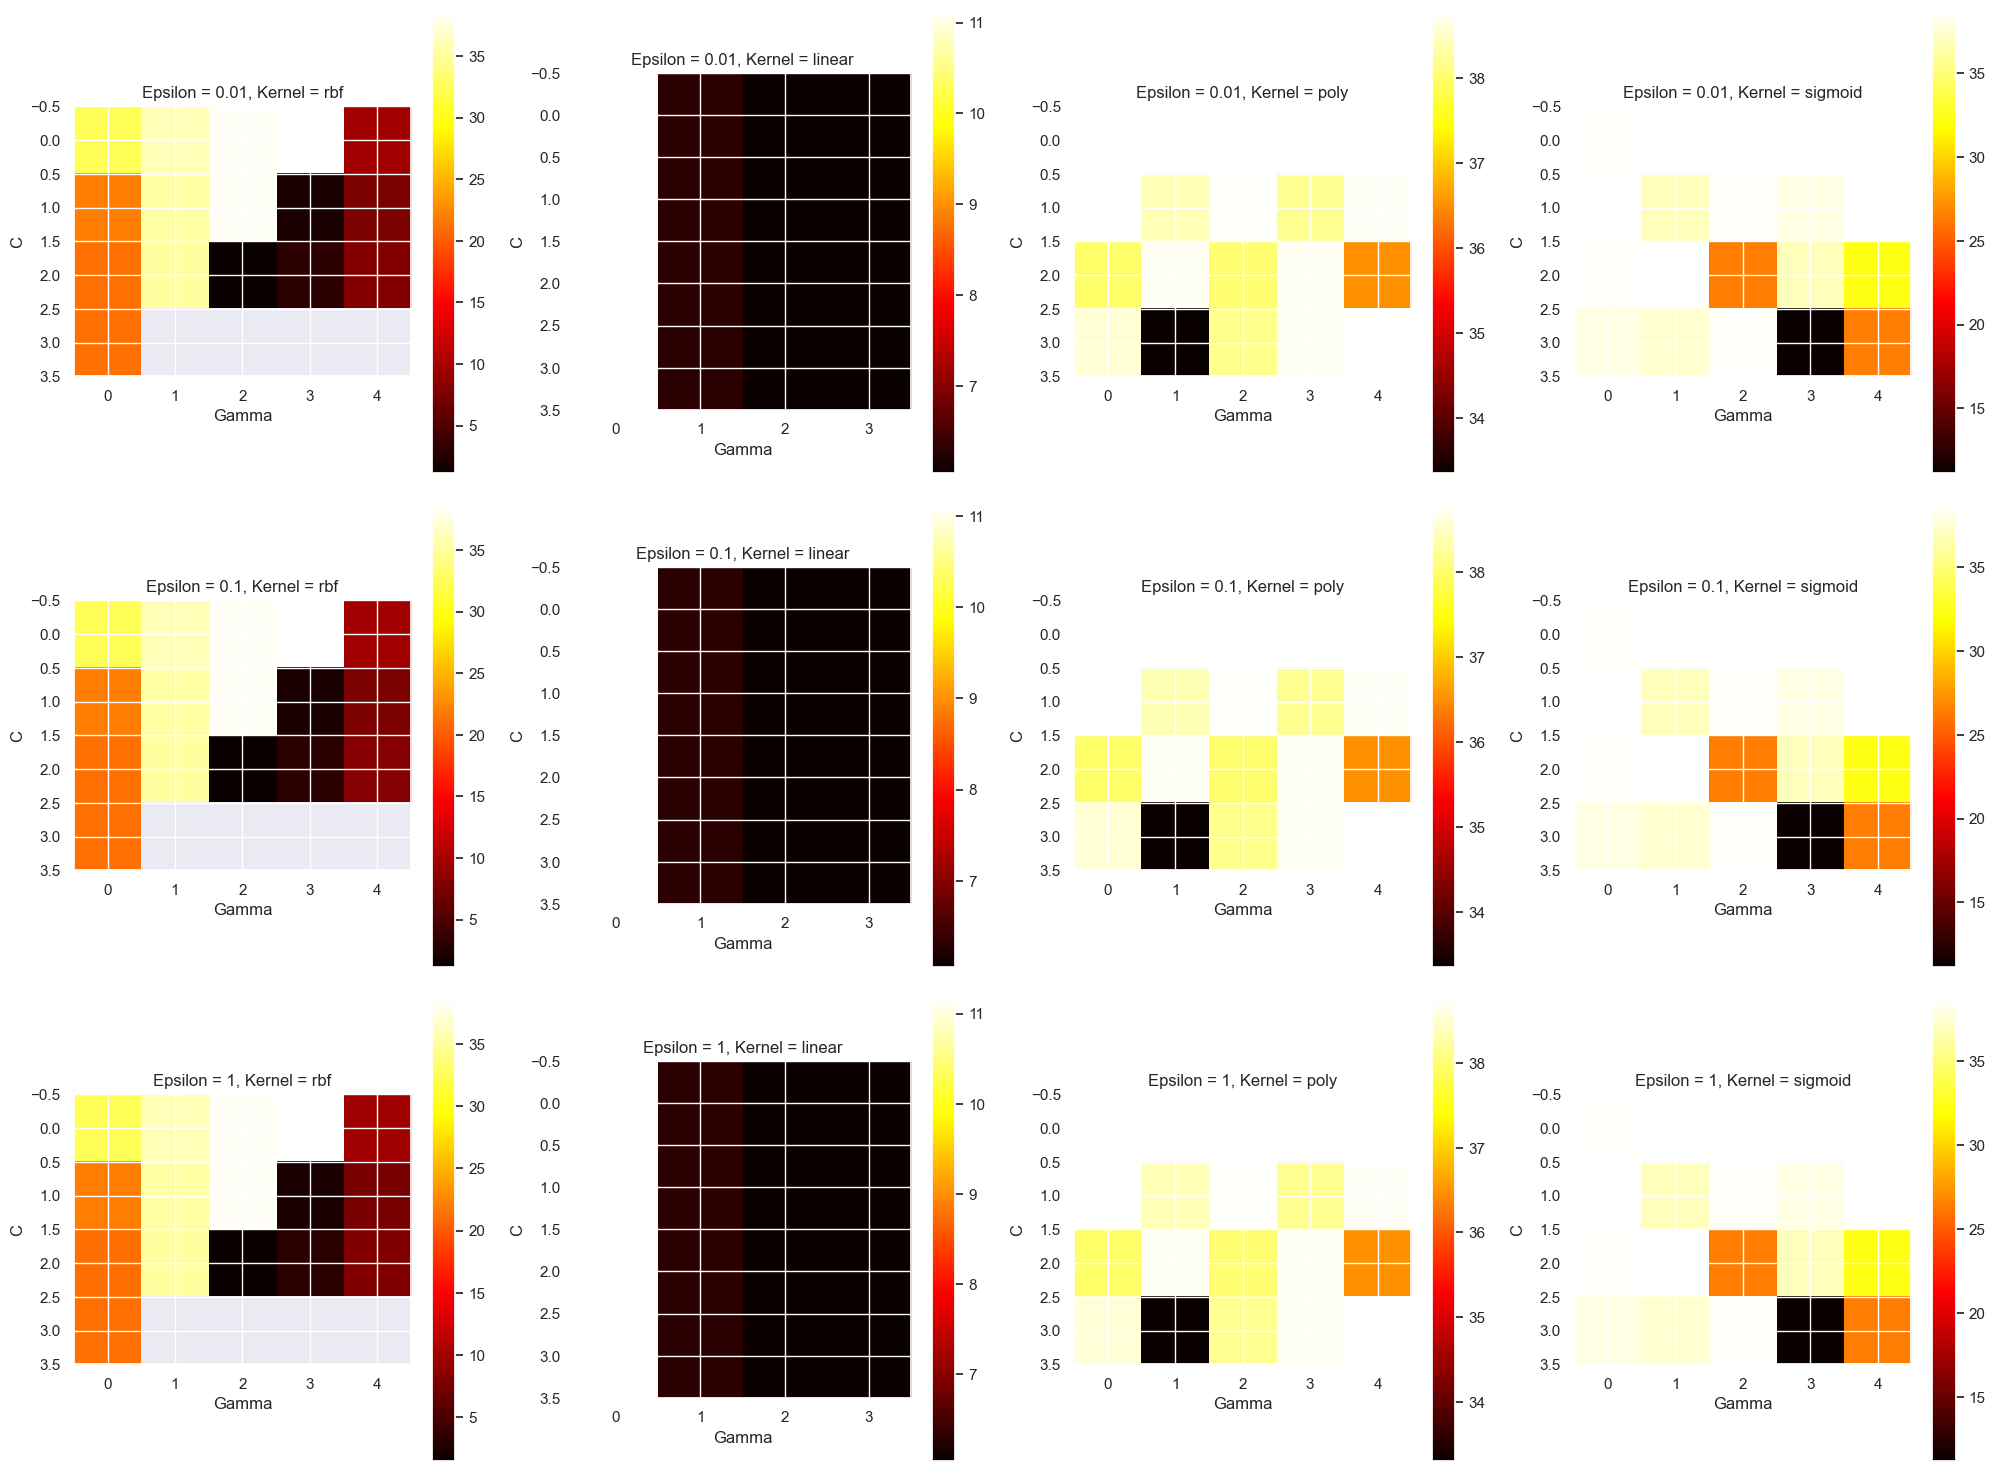

In [22]:
fig, axes = plt.subplots(len(epsilon_range), len(kernel_range), figsize=(20, 15))

for idx, epsilon in enumerate(epsilon_range):
    for kdx, kernel in enumerate(kernel_range):
        scores = get_scores(epsilon, kernel, results, C_range, gamma_range)
        ax = axes[idx, kdx]
        cax = ax.imshow(scores.reshape(len(C_range), -1), interpolation='nearest', cmap=plt.cm.hot)
        ax.set_title(f'Epsilon = {epsilon}, Kernel = {kernel}')
        ax.set_xlabel('Gamma')
        ax.set_ylabel('C')
        plt.colorbar(cax, ax=ax)

plt.tight_layout()
plt.show()

# Test of the model

In [23]:
y_pred = final_model.predict(X_test)

mee = mean_euclidean_error(y_test, y_pred)
r2 = multidim_r2(y_test, y_pred)
rmse = root_mean_squared_error(y_test, y_pred)

print('MEE:', mee)
print('R2:', r2)
print('RMSE:', rmse)

MEE: 1.1601799299422333
R2: 0.9977998159550684
RMSE: 1.0359260622588489


# Save model

In [24]:
model_path = os.path.join(MODEL_FOLDER, 'SVR_model.joblib')
dump(model, model_path, compress=3)

['../../trained_models/cup2023/SVR_model.joblib']